# Explore here

In [48]:
# Your code here
from sklearn.datasets import load_breast_cancer
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score

In [49]:
df = pd.read_csv('/workspaces/pauline-DECISION-TREE-ALGO./data/raw/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [50]:
df.shape

(768, 9)

In [51]:
#Revisar si hay nulos:
df.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [52]:
#Revisar si hay constantes o binarias :
df.nunique().sort_values()

Outcome                       2
Pregnancies                  17
BloodPressure                47
SkinThickness                51
Age                          52
Glucose                     136
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
dtype: int64

Outcomes es nuestro y.
Se sabe que todas las variables son númericas.

In [53]:
# Revisamos que no haya fila duplicada:
sum(df.duplicated())

0

In [54]:
#Descripción básica :
df.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.8,3.4,0.0,1.0,3.0,6.0,17.0
Glucose,768.0,120.9,32.0,0.0,99.0,117.0,140.2,199.0
BloodPressure,768.0,69.1,19.4,0.0,62.0,72.0,80.0,122.0
SkinThickness,768.0,20.5,16.0,0.0,0.0,23.0,32.0,99.0
Insulin,768.0,79.8,115.2,0.0,0.0,30.5,127.2,846.0
BMI,768.0,32.0,7.9,0.0,27.3,32.0,36.6,67.1
DiabetesPedigreeFunction,768.0,0.5,0.3,0.1,0.2,0.4,0.6,2.4
Age,768.0,33.2,11.8,21.0,24.0,29.0,41.0,81.0
Outcome,768.0,0.3,0.5,0.0,0.0,0.0,1.0,1.0


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

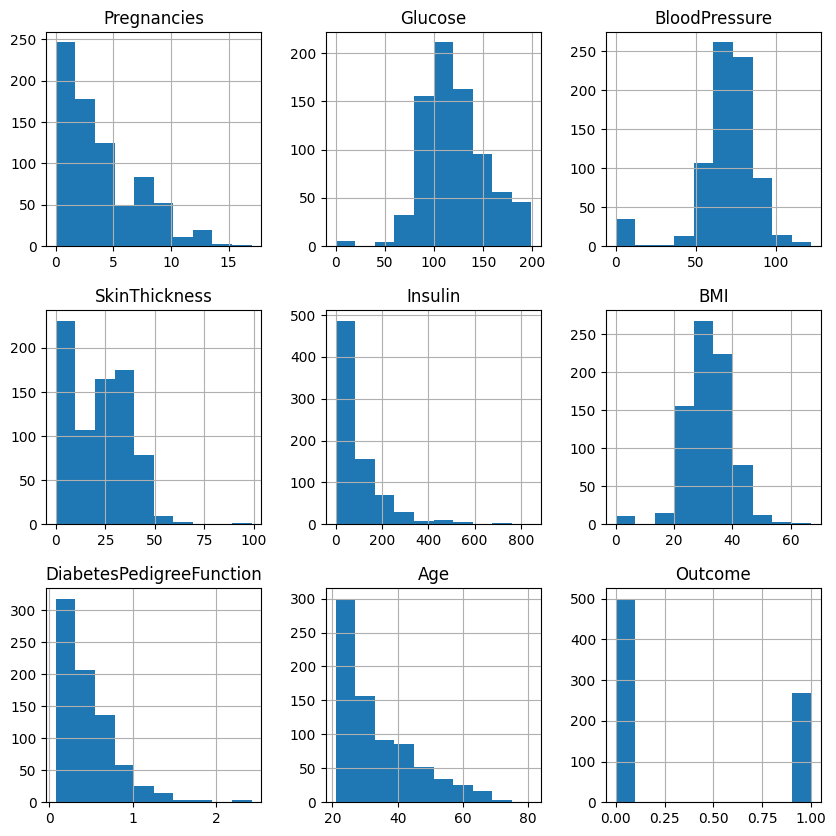

In [55]:
#Son todas numéricas y son solo 9, visualizamos frcuencia de cada varaibles: 
df.hist(figsize=(10, 10)) 

In [56]:
#Miramos para el objectivo y (Outcome), cuanto s exactamente tienen diabete (1) o no (0):
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

<Axes: >

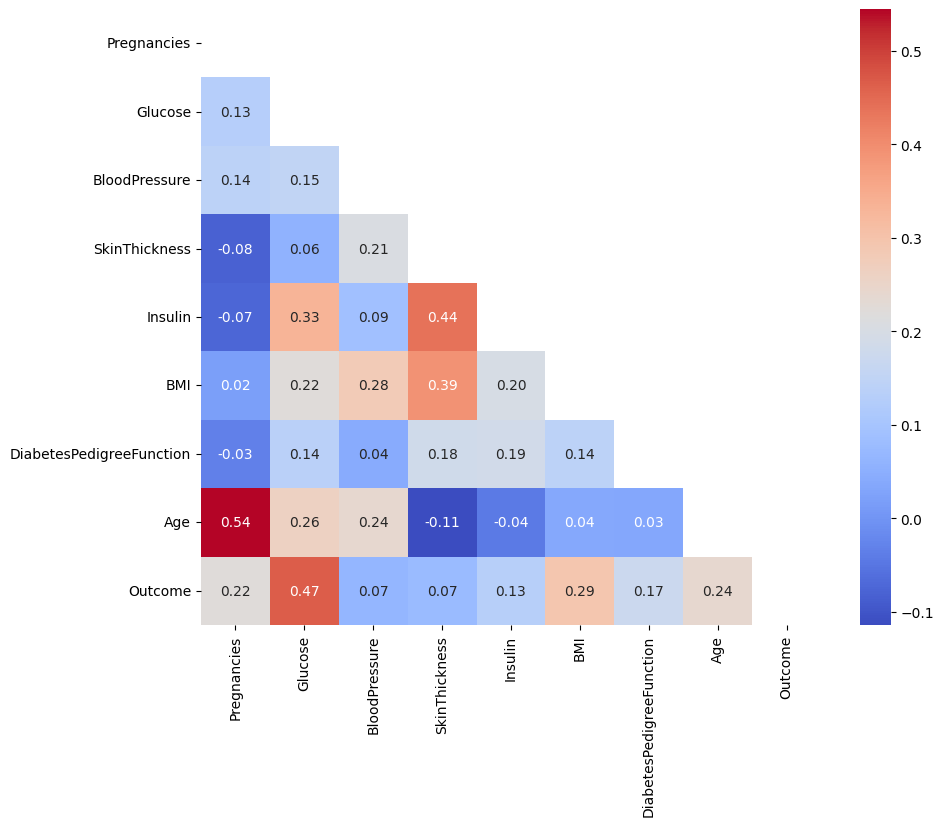

In [57]:
#Miramos correlación :
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')

Más alta correlación con Outcome : Glucose y BMI

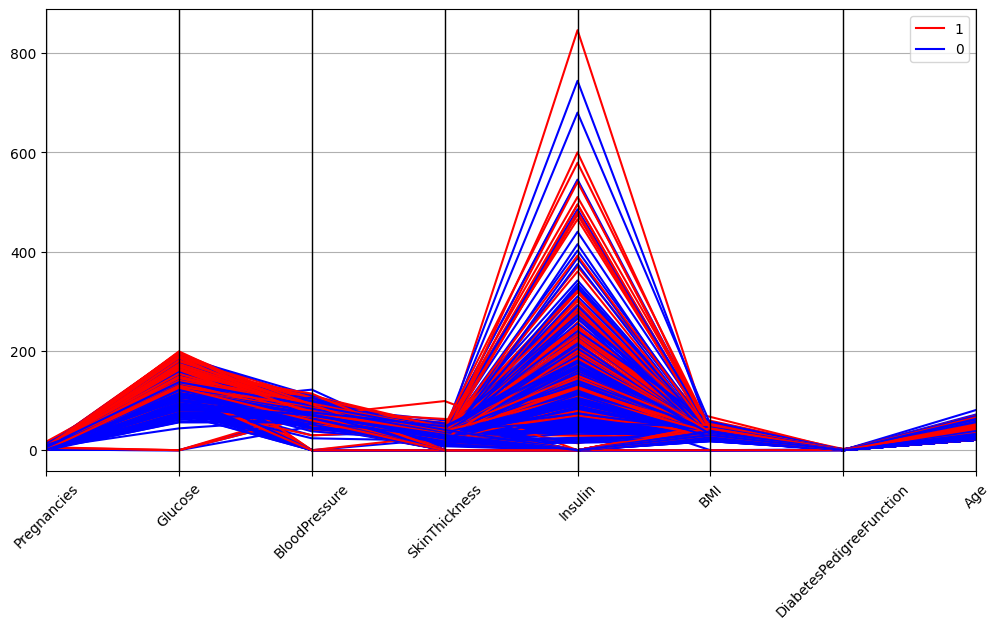

In [60]:
#Vizualisación : 


plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

#Cada linea del grafico = una fila del df, eje vertical = las columnas, en rojo = tiene diabete, en azul = no tiene 

- Glocuse : todas las lineas más arriba están rojas y juntas.
- Insulina : lineas rojas y azules estan más separadas que para otras caracteristicas, y suben muy arriba

Serían entonces esas 2 variables que separan mejor los pacientes, y entonces  las más relevantes para el modelo?
Vamos a mirar más precisamente escalando:

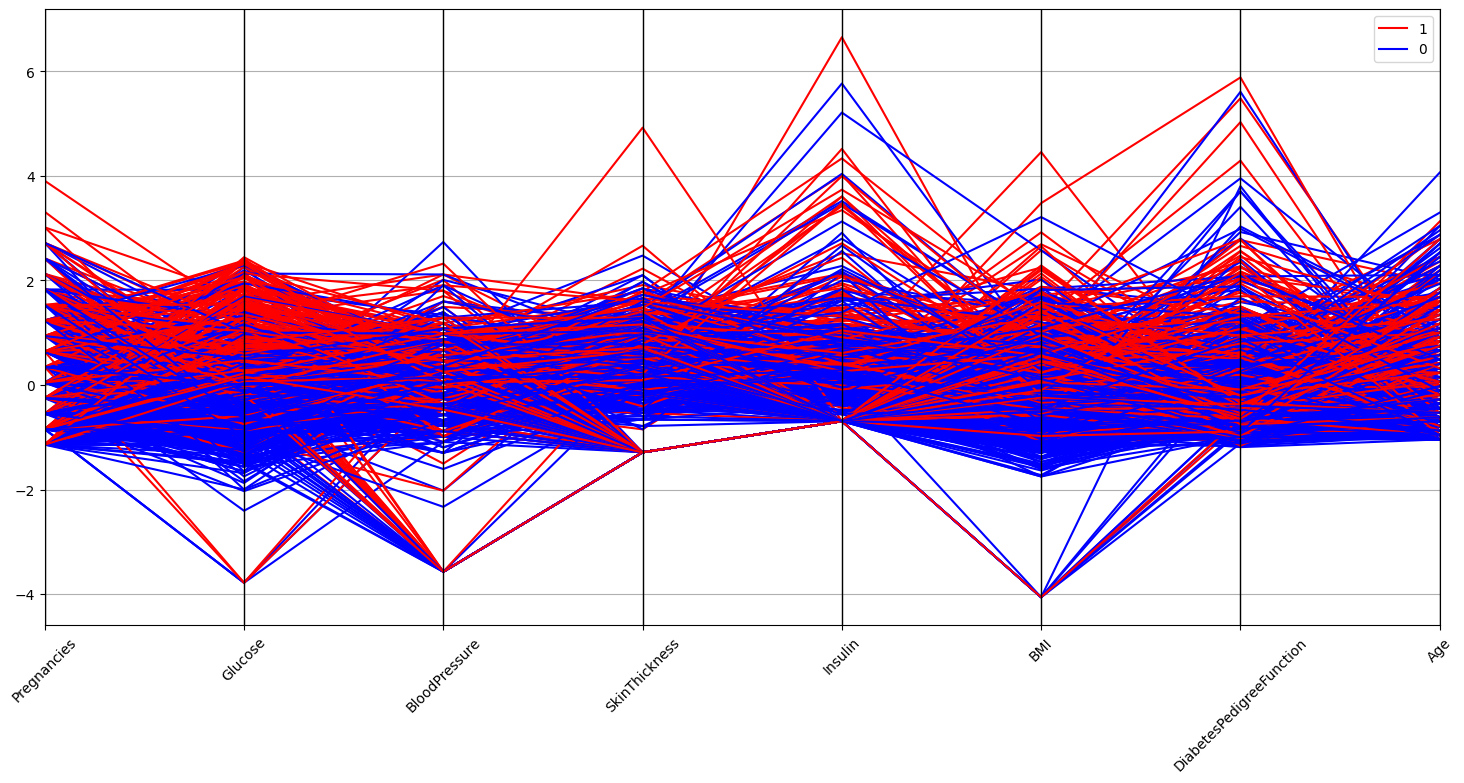

In [68]:
#Pero igual escalamos las variables para compararlas mejor:
df_sc = pd.DataFrame(data=StandardScaler().fit_transform(df.drop(['Outcome'], axis=1)), columns=df.columns[:-1])
df_sc['Outcome'] = df['Outcome']
plt.figure(figsize=(18, 8))
pd.plotting.parallel_coordinates(df_sc, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

In [69]:
#Separamos train y test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Outcome'],axis=1), df['Outcome'], test_size=0.2, random_state=42)
#Aqui no se necesita escalar

In [70]:
#Creamos un árbol complejo y uno simple
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=X_train.shape[1]//2, min_samples_leaf=20, random_state=42).fit(X_train, y_train) #max = la mitad de las variables
complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42).fit(X_train, y_train)

#Aplicamos los árboles sobre los datos de entrenamiento y de test
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

In [71]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    #Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    #Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    #Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    #Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [72]:
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000,1.000000,1.000000
Test,0.746753,0.672269,0.742424,0.625,0.727273,0.757576
Diferencia,0.253247,0.327731,0.257576,0.375,0.272727,0.242424


In [73]:
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)


,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.737785,0.663883,0.739823,0.597744,0.746479,0.733167
Test,0.636364,0.594203,0.660606,0.493976,0.745455,0.575758
Diferencia,0.101421,0.069680,0.079217,0.103768,0.001024,0.157410


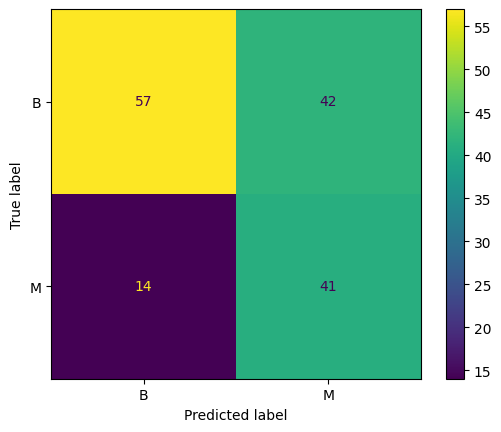

In [74]:
cm = confusion_matrix(y_test, test_pred_simple)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
disp.plot()

In [75]:
text_representation = export_text(simple_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- Age <= 28.50
|   |--- Glucose <= 127.50
|   |   |--- BMI <= 30.95
|   |   |   |--- class: 0
|   |   |--- BMI >  30.95
|   |   |   |--- class: 0
|   |--- Glucose >  127.50
|   |   |--- SkinThickness <= 31.50
|   |   |   |--- class: 0
|   |   |--- SkinThickness >  31.50
|   |   |   |--- class: 1
|--- Age >  28.50
|   |--- BMI <= 27.85
|   |   |--- Glucose <= 123.00
|   |   |   |--- class: 0
|   |   |--- Glucose >  123.00
|   |   |   |--- class: 0
|   |--- BMI >  27.85
|   |   |--- Insulin <= 142.00
|   |   |   |--- class: 1
|   |   |--- Insulin >  142.00
|   |   |   |--- class: 1



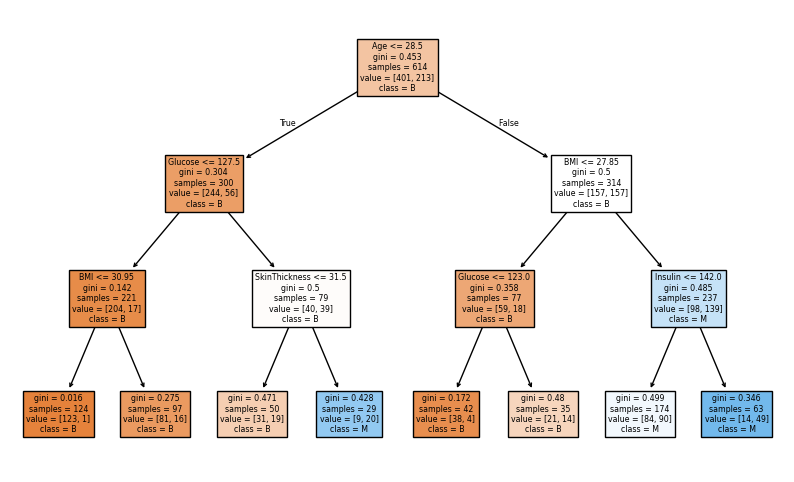

In [76]:
plt.figure(figsize=(10, 6))
plot_tree(simple_tree, feature_names=X_train.columns, class_names=['B','M'], filled=True)
plt.show()